# Proyecto de Aprendizaje de Máquina
Este notebook evalúan tres modelos para predecir la severidad de casos médicos utilizando características clínicas.

## 1. Importación de librerías

In [ ]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score

## 2. Carga y preparación del dataset

In [117]:
# Cargar archivo
df = pd.read_csv('dataset_elpino.csv', delimiter=';')

# Extraer código numérico del GRD
df['GRD_codigo'] = df['GRD'].astype(str).str.extract(r'(\d+)', expand=False)

# Extraer severidad como última cifra
df['Severidad'] = df['GRD_codigo'].str[-1]

# Mapear severidad a categorías
df = df[df['Severidad'].isin(['1', '2', '3'])]  # eliminar datos malformados
df['Severidad'] = df['Severidad'].map({'1': 'baja', '2': 'media', '3': 'alta'})


## 3. Selección de variables y target

In [118]:
# Seleccionar columnas relevantes
diag_cols = [col for col in df.columns if 'diag' in col.lower()]
proc_cols = [col for col in df.columns if 'proced' in col.lower()]
features = diag_cols + proc_cols + ['Edad en años', 'Sexo (Desc)']

# Filtrar solo columnas usadas
X = df[features].copy()
y = df['Severidad']


In [119]:
# Extraer el código numérico del GRD
df['GRD_codigo'] = df['GRD'].astype(str).str.extract(r'(\d+)', expand=False)

# Extraer severidad como último dígito del código GRD
df['Severidad'] = df['GRD_codigo'].str[-1]
df = df[df['Severidad'].isin(['1', '2', '3'])]  # Filtramos solo severidades válidas
df['Severidad'] = df['Severidad'].map({'1': 'baja', '2': 'media', '3': 'alta'})

# Estadísticas descriptivas
# Edad media
edad_media = df['Edad en años'].mean()

# Distribución de severidad
dist_severidad = df['Severidad'].value_counts(normalize=True) * 100

# Distribución de sexo
dist_sexo = df['Sexo (Desc)'].value_counts(normalize=True) * 100

# Mostrar resultados
print(f"Edad media: {edad_media:.2f} años\n")
print("Distribución de severidad GRD (%):")
print(dist_severidad.round(2), "\n")
print("Distribución de sexo (%):")
print(dist_sexo.round(2))


Edad media: 39.43 años

Distribución de severidad GRD (%):
Severidad
baja     50.23
alta     26.07
media    23.70
Name: proportion, dtype: float64 

Distribución de sexo (%):
Sexo (Desc)
Mujer     66.05
Hombre    33.95
Name: proportion, dtype: float64


In [120]:
# Extraer el código numérico del GRD
df['GRD_codigo'] = df['GRD'].astype(str).str.extract(r'(\d+)', expand=False)

# Extraer severidad como último dígito del código GRD
df['Severidad'] = df['GRD_codigo'].str[-1]
df = df[df['Severidad'].isin(['1', '2', '3'])]  # Filtrar severidades válidas

# Reclasificar severidad: alta (3) vs no alta (1,2)
df['Severidad_binaria'] = df['Severidad'].map({'1': 'No Alta', '2': 'No Alta', '3': 'Alta'})

# Filtrar solo casos Alta
df_alta = df[df['Severidad_binaria'] == 'Alta']

# Edad media para casos Alta
edad_media_alta = df_alta['Edad en años'].mean()

# Distribución de sexo en casos Alta
dist_sexo_alta = df_alta['Sexo (Desc)'].value_counts(normalize=True) * 100

# Distribución general Alta vs No Alta
dist_severidad_binaria = df['Severidad_binaria'].value_counts(normalize=True) * 100

# Mostrar resultados
print(f"Edad media (solo severidad alta): {edad_media_alta:.2f} años\n")
print("Distribución de severidad (Alta vs No Alta) (%):")
print(dist_severidad_binaria.round(2))
print("Distribución de sexo (solo severidad alta) (%):")
print(dist_sexo_alta.round(2), "\n")

Edad media (solo severidad alta): 49.61 años

Distribución de severidad (Alta vs No Alta) (%):
Severidad_binaria
No Alta    73.93
Alta       26.07
Name: proportion, dtype: float64
Distribución de sexo (solo severidad alta) (%):
Sexo (Desc)
Mujer     53.19
Hombre    46.81
Name: proportion, dtype: float64 



## 4. Modelo Random Forest

In [121]:
# Extraer código numérico del GRD y severidad
df['GRD_codigo'] = df['GRD'].astype(str).str.extract(r'(\d+)', expand=False)
df['Severidad'] = df['GRD_codigo'].str[-1]

# Mantener solo severidades válidas
df = df[df['Severidad'].isin(['1', '2', '3'])]

# Mapear severidad a texto
df['Severidad'] = df['Severidad'].map({'1': 'baja', '2': 'media', '3': 'alta'})

# NUEVO: variable binaria: 1 si es 'alta', 0 si no
df['Severidad_binaria'] = (df['Severidad'] == 'alta').astype(int)

# Seleccionar columnas relevantes
diag_cols = [col for col in df.columns if 'diag' in col.lower()]
proc_cols = [col for col in df.columns if 'proced' in col.lower()]
features = diag_cols + proc_cols + ['Edad en años', 'Sexo (Desc)']

# Variables predictoras y objetivo
X = df[features].copy()
y = df['Severidad_binaria']  # Objetivo binario

# Separar tipos de columnas
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preprocesador
preprocessor = ColumnTransformer(transformers=[
    ('num', SimpleImputer(strategy='median'), numeric_cols),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]), categorical_cols)
])

# Modelo: Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Pipeline completo
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# División de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entrenamiento
pipeline.fit(X_train, y_train)

# Evaluación
y_pred = pipeline.predict(X_test)
print("Classification Report random forest:")
print(classification_report(y_test, y_pred, target_names=['No Alta', 'Alta']))


Classification Report random forest:
              precision    recall  f1-score   support

     No Alta       0.90      0.96      0.93      3225
        Alta       0.87      0.68      0.76      1144

    accuracy                           0.89      4369
   macro avg       0.88      0.82      0.85      4369
weighted avg       0.89      0.89      0.89      4369



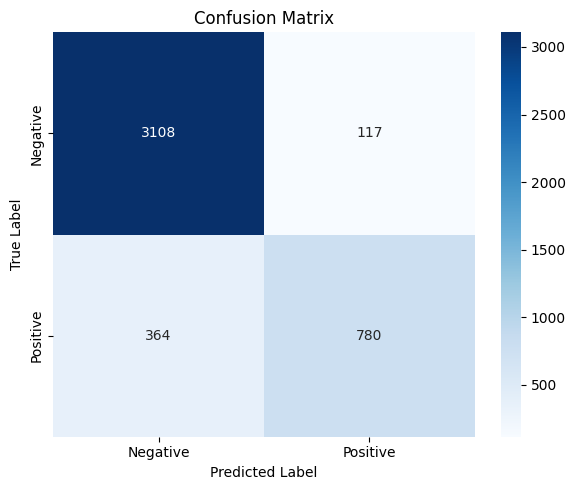

In [122]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
xlabels = ['Negative', 'Positive']
ylabels = ['Negative', 'Positive']

# Crear figura
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=xlabels, yticklabels=ylabels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

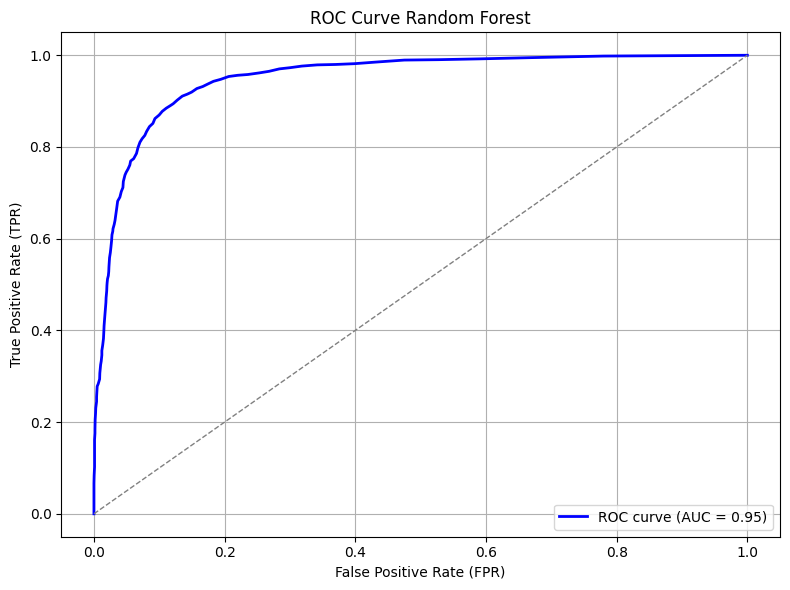

In [123]:
# Obtener probabilidades para clase 'Alta' (1)
y_proba = pipeline.predict_proba(X_test)[:, 1]

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Graficar curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')  # línea diagonal
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve Random Forest')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [124]:
# Procesar severidad
df['GRD_codigo'] = df['GRD'].astype(str).str.extract(r'(\d+)', expand=False)
df['Severidad'] = df['GRD_codigo'].str[-1]
df = df[df['Severidad'].isin(['1', '2', '3'])]
df['Severidad'] = df['Severidad'].map({'1': 'baja', '2': 'media', '3': 'alta'})
df['Severidad_binaria'] = (df['Severidad'] == 'alta').astype(int)

# Seleccionar columnas
diag_cols = [col for col in df.columns if 'diag' in col.lower()]
proc_cols = [col for col in df.columns if 'proced' in col.lower()]
features = diag_cols + proc_cols + ['Edad en años', 'Sexo (Desc)']
X = df[features].copy()
y = df['Severidad_binaria']

# Columnas categóricas y numéricas
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preprocesador
preprocessor = ColumnTransformer(transformers=[
    ('num', SimpleImputer(strategy='median'), numeric_cols),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]), categorical_cols)
])

# Modelo con pesos balanceados
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

# Pipeline completo
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entrenar
pipeline.fit(X_train, y_train)

# Predicción con ajuste de umbral
y_proba = pipeline.predict_proba(X_test)[:, 1]
threshold = 0.35  # Se puede probar con 0.25, 0.35, etc.
y_pred_custom = (y_proba >= threshold).astype(int)

# Resultados
print("Classification Report random forest (adjusted threshold):")
print(classification_report(y_test, y_pred_custom, target_names=['No Alta', 'Alta']))


Classification Report random forest (adjusted threshold):
              precision    recall  f1-score   support

     No Alta       0.94      0.89      0.91      3225
        Alta       0.73      0.84      0.78      1144

    accuracy                           0.88      4369
   macro avg       0.84      0.87      0.85      4369
weighted avg       0.89      0.88      0.88      4369



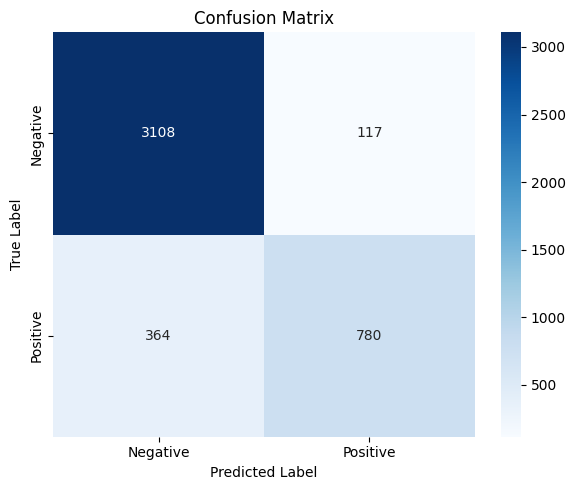

In [125]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
xlabels = ['Negative', 'Positive']
ylabels = ['Negative', 'Positive']

# Crear figura
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=xlabels, yticklabels=ylabels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

## 5. Modelo Random Forest (Umbral Ajustado)

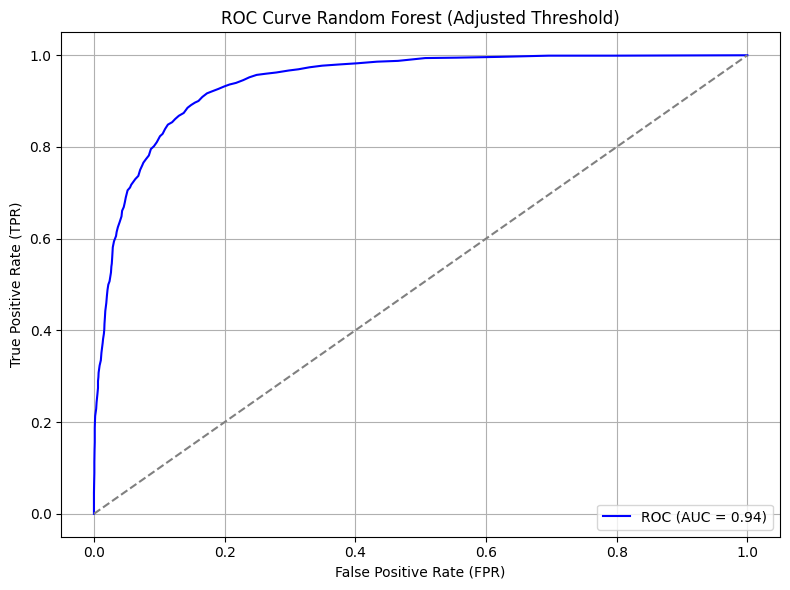

In [126]:
# Probabilidades de predicción
y_proba = pipeline.predict_proba(X_test)[:, 1]

# Calcular curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Graficar
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # diagonal
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve Random Forest (Adjusted Threshold)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


## 6. Modelo Regresión Logística

In [127]:
# Extraer código numérico del GRD y severidad
df['GRD_codigo'] = df['GRD'].astype(str).str.extract(r'(\d+)', expand=False)
df['Severidad'] = df['GRD_codigo'].str[-1]

# Mantener solo severidades válidas
df = df[df['Severidad'].isin(['1', '2', '3'])]

# Mapear severidad a texto
df['Severidad'] = df['Severidad'].map({'1': 'baja', '2': 'media', '3': 'alta'})

# Variable binaria: 1 si es 'alta', 0 si no
df['Severidad_binaria'] = (df['Severidad'] == 'alta').astype(int)

# Selección de variables
diag_cols = [col for col in df.columns if 'diag' in col.lower()]
proc_cols = [col for col in df.columns if 'proced' in col.lower()]
features = diag_cols + proc_cols + ['Edad en años', 'Sexo (Desc)']

X = df[features].copy()
y = df['Severidad_binaria']

# Preprocesamiento
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

preprocessor = ColumnTransformer(transformers=[
    ('num', SimpleImputer(strategy='median'), numeric_cols),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]), categorical_cols)
])

# Modelo: Regresión Logística con balanceo de clases
model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

# Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# División
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entrenamiento
pipeline.fit(X_train, y_train)

# Predicción y evaluación
y_pred = pipeline.predict(X_test)
print(" Classification Report - Logistic Regression:")
print(classification_report(y_test, y_pred, target_names=['No Alta', 'Alta']))


 Classification Report - Logistic Regression:
              precision    recall  f1-score   support

     No Alta       0.95      0.95      0.95      3225
        Alta       0.86      0.86      0.86      1144

    accuracy                           0.93      4369
   macro avg       0.90      0.90      0.90      4369
weighted avg       0.93      0.93      0.93      4369



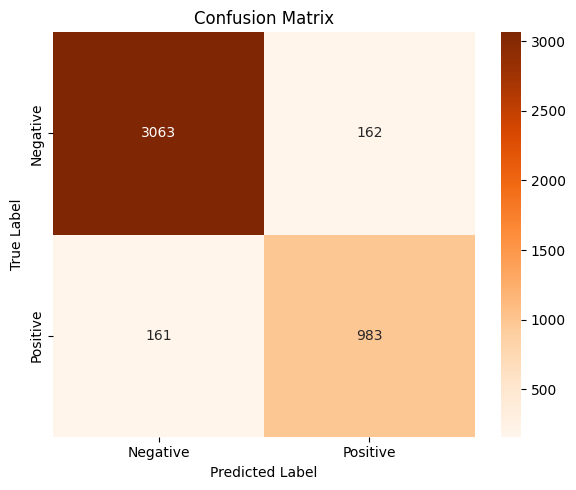

In [128]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
xlabels = ['Negative', 'Positive']
ylabels = ['Negative', 'Positive']

# Crear figura
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=xlabels, yticklabels=ylabels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

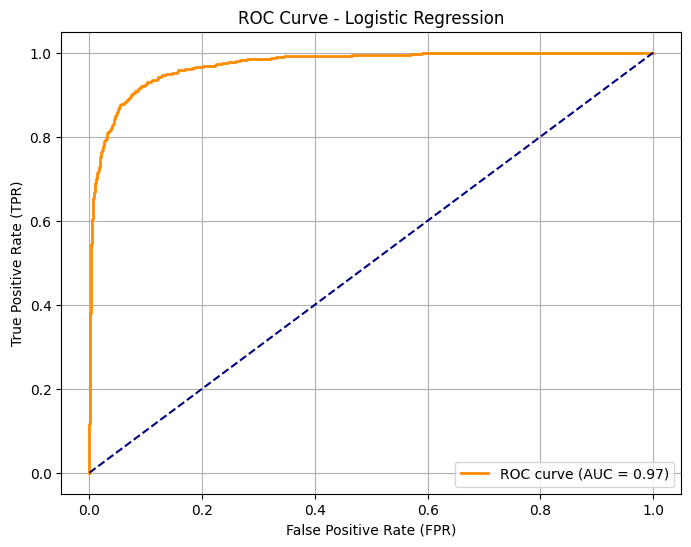

In [129]:
# Probabilidades del modelo para la clase 'Alta'
y_scores = pipeline.predict_proba(X_test)[:, 1]

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = roc_auc_score(y_test, y_scores)

# Graficar
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


## 7. Conclusión

Los trees modelos fueron entrenados y evaluados. A partir de los resultados de precisión, podemos seleccionar el que mejor se ajuste al problema según el contexto médico y la métrica priorizada.